In [194]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
import numpy as np
import hdbscan
import os.path
from seaborn import scatterplot

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import socket
import struct



## Preparation

In [195]:
import pandas as pd
import os.path
FILEID = 1
FILEIDS = [1, 3, 36, 39, 49, 52]
LOGFILE = f"https://mcfp.felk.cvut.cz/publicDatasets/IoTDatasets/CTU-IoT-Malware-Capture-{FILEID}-1/bro/conn.log.labeled"
NUMERIC_COLUMNS = ['ts', 'orig_p', 'resp_p', "orig_bytes", "resp_bytes", "missed_bytes", "orig_pkts", 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'duration'] # integer columns

In [196]:
def convert_to_csv(FILEID):
    if not os.path.isfile(f'csv/capture{FILEID}_1.csv'):
        LOGFILE = f"https://mcfp.felk.cvut.cz/publicDatasets/IoTDatasets/CTU-IoT-Malware-Capture-{FILEID}-1/bro/conn.log.labeled"
        fieldsIN = ['ts', 'uid', 'orig_h', 'orig_p', 'resp_h', 'resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state',
                'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label', 'detailed_label']
        df = pd.read_csv(LOGFILE, sep="\x09|\x20\x20\x20", skiprows=10, skipfooter=2,
                        names=fieldsIN, header=None, engine='python')
                                
        df = df.drop(['tunnel_parents'], axis=1)
        df.to_csv(f'csv/capture{FILEID}_1.csv')
        print(df.shape)
        for column in NUMERIC_COLUMNS:
            df[column] = pd.to_numeric(df[column], errors='coerce')
        return df


In [217]:
def convert_ipv4(addr):
    return struct.unpack("!I", socket.inet_aton(addr))[0]

def convert_label(l):
    return 1 if l == 'Malicious' else 0

def to_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [218]:
def norm_df(df, rows=None):
    df = df.dropna()
    df = df.replace('-', np.nan)
    df['orig_h'] = df['orig_h'].apply(convert_ipv4)
    df['resp_h'] = df['resp_h'].apply(convert_ipv4)
    df = pd.get_dummies(df, columns=['proto'])
    df = df.drop(['Unnamed: 0','service', 'duration', 'missed_bytes', 'history', 'uid', 'conn_state', 'local_orig', 'local_resp', 'orig_ip_bytes', 'resp_ip_bytes', 'orig_pkts', 'resp_pkts', 'detailed_label'], axis=1)
    df['label'] = df['label'].apply(convert_label)
    df['resp_bytes'] = df['resp_bytes'].apply(to_int)
    df['orig_bytes'] = df['orig_bytes'].apply(to_int)
    df['ts'] = df['ts'].astype(np.int32)
    for i in ['proto_icmp', 'proto_udp', 'proto_tcp']:
        df[i] = df[i].astype(int)
    df.reset_index()
    if (rows): return df[:rows]
    else: return df

In [219]:
SOURCEDF = norm_df(pd.read_csv('csv/capture1_1.csv'), 100000)
print(f"{SOURCEDF.shape}\n")
print(f'{SOURCEDF.dtypes}\n')
print(f"data categories = [Malicious: {SOURCEDF[SOURCEDF['label'] == 1].shape[0]}, Benign: {SOURCEDF[SOURCEDF['label'] == 0].shape[0]}]")
SOURCEDF.head()


(100000, 11)

ts              int32
orig_h          int64
orig_p          int64
resp_h          int64
resp_p          int64
orig_bytes    float64
resp_bytes    float64
label           int64
proto_icmp      int64
proto_tcp       int64
proto_udp       int64
dtype: object

data categories = [Malicious: 55044, Benign: 44956]


,ts,orig_h,orig_p,resp_h,resp_p,orig_bytes,resp_bytes,label,proto_icmp,proto_tcp,proto_udp
0,1525879831,3232261223,41101,1864898353,23,NaN,NaN,1,0,1,0
1,1525879832,3232261223,60905,2209273747,23,0.0,0.0,1,0,1,0
2,1525879832,3232261223,44301,1529491263,23,NaN,NaN,1,0,1,0
3,1525879832,3232261223,50244,2027056328,23,NaN,NaN,1,0,1,0
4,1525879833,3232261223,34243,2466726347,49560,0.0,0.0,0,0,1,0


## Clustering

In [ ]:
def hdbscanner(df):
    hdbscan_obj = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, metric='euclidean', min_cluster_size=5, min_samples=None, p=None).fit(df)
    labels = hdbscan_obj.labels_
    df['category'] = pd.Series(labels)
    return df


In [ ]:
# takes 3m52.2s
df1_ = SOURCEDF.loc[:, ['orig_bytes','resp_bytes','orig_p', 'resp_p']]
df1 = hdbscanner(df1_)

In [ ]:
df1.head(10)


,orig_bytes,resp_bytes,orig_p,resp_p,category
0,NaN,NaN,41101,23,-1
1,0,0,60905,23,-1
2,NaN,NaN,44301,23,-1
3,NaN,NaN,50244,23,-1
4,0,0,34243,49560,-1
5,NaN,NaN,34840,21288,-1
6,NaN,NaN,58525,23,-1
7,NaN,NaN,43849,8080,-1
8,NaN,NaN,40973,8080,-1
9,0,0,52259,23,594


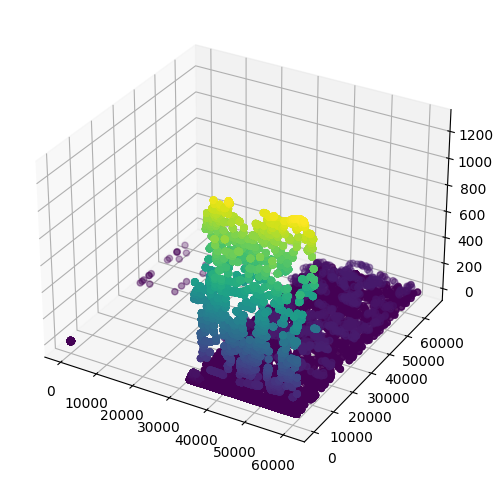

In [ ]:
fig = plt.figure(figsize=(6,6))

ax = plt.axes(projection='3d')
#sc = ax.scatter(data=df1, x='orig_p', y='resp_p', z='category', s=40, c='category', marker='o', cmap='plasma', alpha=1)

ax.scatter3D(df1['orig_p'], df1['resp_p'], df1['category'], c=df1['category'])

plt.show()

## Model Training using linear Kernel
from [here](https://datagy.io/python-support-vector-machines/)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:

X = df1[['orig_p', 'resp_p']]
y = df1['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)


In [ ]:
def train_linear():
    # Building and training our model
    clf = SVC(kernel='linear', verbose=False)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print(f"Acccuracy: {accuracy_score(y_test, predictions)}")
    # interrupted after 526 minutes
    return clf

In [ ]:
def visualise_linear(clf):
# Visualizing the linear function for our SVM classifier
    w = clf.coef_[0]
    b = clf.intercept_[0]
    x_visual = np.linspace(0,60000)
    y_visual = -(w[0] / w[1]) * x_visual - b / w[1]

    scatterplot(data = X_train, x='orig_p', y='resp_p', hue=y_train)
    plt.plot(x_visual, y_visual)
    plt.show()

## Model Training using better Kernel
**THIS DID NOT WORK AS EXPECTED AND SINCE SVM IS NOT NECESSARY ANYWAYS, IT WONT BE FIXED**

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer

In [ ]:
def encoder(df: pd.DataFrame):
    X = df.drop(['label'], axis=1)
    y = df['label'].to_frame()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)
    column_transformer = make_column_transformer(
    (OneHotEncoder(), ['orig_h', 'resp_h', 'proto']),
    remainder='passthrough')
    X_train = column_transformer.fit_transform(X_train)
    X_train = pd.DataFrame(data=X_train, columns=column_transformer.get_feature_names_out())
    print(X_train.head())

# encoder(SOURCEDF)

## Training using ANN
link: [here](https://www.analyticsvidhya.com/blog/2021/10/implementing-artificial-neural-networkclassification-in-python-from-scratch/)

or [here](https://towardsdatascience.com/visualizing-artificial-neural-networks-anns-with-just-one-line-of-code-b4233607209e)

this for encoding: [encoding](https://datagy.io/sklearn-one-hot-encode/)

In [220]:
import tensorflow as tf

In [221]:
X = SOURCEDF.drop(['label'], axis=1)
y = SOURCEDF['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)


In [222]:
X_train.dtypes

ts              int32
orig_h          int64
orig_p          int64
resp_h          int64
resp_p          int64
orig_bytes    float64
resp_bytes    float64
proto_icmp      int64
proto_tcp       int64
proto_udp       int64
dtype: object

In [223]:
y_train

17853    1
55890    0
89462    0
1921     0
27367    1
        ..
65615    1
77655    1
79683    1
56088    0
38408    1
Name: label, Length: 75000, dtype: int64

In [224]:
def ann(X_train, y_train):
    ann = tf.keras.models.Sequential()
    ann.add(tf.keras.layers.Dense(units=6,activation="relu")) # 6,3
    ann.add(tf.keras.layers.Dense(units=6,activation="relu")) # 6,3
    ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
    ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])
    ann.fit(X_train,y_train,batch_size=32,epochs = 5, verbose=1)
    return ann

ann(X_train, y_train)

Epoch 1/5
2344/2344 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.4485
Epoch 2/5
2344/2344 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.4485
Epoch 3/5
2344/2344 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.4485
Epoch 4/5
2344/2344 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.4485
Epoch 5/5
2344/2344 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.4485
